In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
tickers = ['AAPL', 'AMZN', 'MSFT', 'PFE']
weights = np.array([0.3, 0.3, 0.3, 0.1])

period = '1y'
conf_level = 0.05

def get_data(tickers, period):
    data = yf.download(tickers, period=period)['Close']
    return data.interpolate(method='linear')


prices = get_data(tickers, period)
log_returns = np.log(prices / prices.shift(1)).dropna()
portfolio_log_returns = log_returns.dot(weights)

while True:
    try:
        method = int(input("Select VaR method 1 = Historical, 2 = Parametric, 3 = Monte Carlo: "))
        if method in [1, 2, 3]:
            break
        else:
            print("Error: Insert a number between 1 and 3.")
            
    except ValueError:
        print("Error: Insert a correct number (1, 2, or 3).")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


Historical Value at Risk

In [3]:
def historical_VaR(returns, confidence_level=0.05):
    VaR = np.percentile(returns, confidence_level*100)
    ES = returns[returns <= VaR].mean()
    df = pd.DataFrame({'Returns' : returns})
    df['Breach'] = df['Returns'] < VaR
    breaches = df[df['Breach'] == True]['Returns']

    return VaR, ES, breaches

Parametric Value at Risk

In [4]:
def parametric_VaR(returns, confidence_level=0.05):
    df, loc, scale = st.t.fit(returns)
    VaR = st.t.ppf(confidence_level, df=df, loc=loc, scale=scale)
    ES = returns[returns <= VaR].mean()
    df = pd.DataFrame({'Returns' : returns})
    df['Breach'] = df['Returns'] < VaR
    breaches = df[df['Breach'] == True]['Returns']

    return VaR, ES, breaches

Monte Carlo Value at Risk

In [5]:
def montecarlo_VaR(returns, confidence_level=0.05, n_sim=10_000):
    df, loc, scale = st.t.fit(returns)
    random_log_returns = st.t.rvs(df=df, loc=loc, scale=scale, size = n_sim)
    VaR = np.percentile(random_log_returns, confidence_level*100)
    ES = random_log_returns[random_log_returns <= VaR].mean()
    df = pd.DataFrame({'Returns' : returns})
    df['Breach'] = df['Returns'] < VaR
    breaches = df[df['Breach'] == True]['Returns']

    return VaR, ES, breaches

Output

In [6]:
if method == 1:
    VaR, ES, breaches = historical_VaR(portfolio_log_returns, conf_level)

    print(f'Historical VaR {conf_level*100}% = {VaR:.4f}')
    print(f'Historical Expected Shortfall (CVaR) {conf_level*100}% = {ES:.4f}')



elif method == 2:
    VaR, ES, breaches = parametric_VaR(portfolio_log_returns, conf_level)

    print(f'Parametric VaR {conf_level*100}% = {VaR:.4f}')
    print(f'Parametric Expected Shortfall (CVaR) {conf_level*100}% = {ES:.4f}')

    x = np.linspace(1.5*VaR, -1.5*VaR)
    df, loc, scale = st.t.fit(portfolio_log_returns)
    pdf = st.t.pdf(x, df=df, loc=loc, scale=scale)

    

elif method == 3:
    VaR, ES, breaches = montecarlo_VaR(portfolio_log_returns, conf_level)

    print(f'Monte Carlo VaR {conf_level*100}% = {VaR:.4f}')
    print(f'Monte Carlo Expected Shortfall (CVaR) {conf_level*100}% = {ES:.4f}')

    df, loc, scale = st.t.fit(portfolio_log_returns)
    random_log_returns = st.t.rvs(df=df, loc=loc, scale=scale, size = 1000)

Parametric VaR 5.0% = -0.0192
Parametric Expected Shortfall (CVaR) 5.0% = -0.0328


Plotting

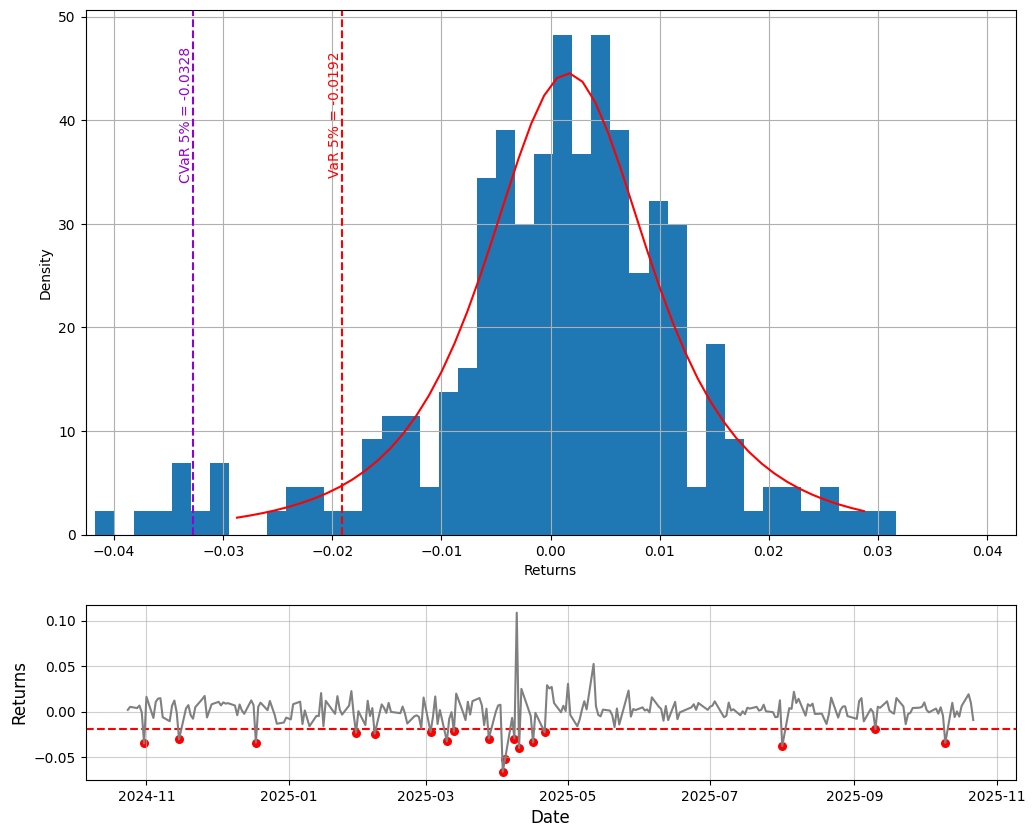

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]}) 

if method == 1:
    portfolio_log_returns.hist(bins=100, density=True, ax=ax[0])

elif method == 2:
    portfolio_log_returns.hist(bins=100, density=True, ax=ax[0])
    ax[0].plot(x, pdf, color='red')
    
elif method == 3:
    ax[0].hist(random_log_returns, bins=100, density=True)


ax[0].set_xlim(1.3*ES, -1.3*ES)
ax[0].axvline(VaR, color='red', linestyle='--', linewidth=1.5)
ax[0].text(VaR,
    ax[0].get_ylim()[1]*0.8,
    f'VaR {conf_level*100:.0f}% = {VaR:.4f}',
    color='red',
    rotation=90,
    va='center',
    ha='right')


ax[0].axvline(ES, color='darkviolet', linestyle='--', linewidth=1.5)
ax[0].text(ES,
    ax[0].get_ylim()[1]*0.8,
    f'CVaR {conf_level*100:.0f}% = {ES:.4f}',
    color='darkviolet',
    rotation=90,
    va='center',
    ha='right')
    

ax[1].axhline(VaR,
    color = 'red',
    linestyle='--',
    label = f'VaR {abs(VaR)*100:.1f}%')


ax[0].set_xlabel('Returns')
ax[0].set_ylabel('Density')


ax[1].plot(portfolio_log_returns, color = 'gray')
ax[1].scatter(breaches.index, breaches.values, color='red', marker='o', s=30, label = 'VaR Breaches')


ax[1].set_ylabel('Returns', fontsize=12)
ax[1].set_xlabel('Date', fontsize=12)
ax[1].grid(True, alpha=0.6)

plt.show()

Backtesting

Kupiec POF Test (POF - Proportion of Failures), Unconditional Coverage

In [8]:
def kupiec_test(returns, var, alpha=0.05):
    T = len(returns)
    x = np.sum(returns < var)
    pi = x/T

    log0 = x * np.log(alpha) + (T - x) * np.log(1 - alpha)
    log1 = x * np.log(pi) + (T - x) * np.log(1 - pi) if 0 < pi < 1 else -np.inf

    LR = -2 * (log0 - log1)
    p_value = 1 - st.chi2.cdf(LR, df=1)

    print(f'Number of violations: {x}')
    print(f'Kupiec\'s Statistic (LR): {LR:.4f}')
    print(f'p-value: {p_value:.4f}')

kupiec_test(portfolio_log_returns, VaR)

Number of violations: 18
Kupiec's Statistic (LR): 2.3027
p-value: 0.1292
